In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import mean_squared_log_error
import optuna
import numpy as np

C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df=pd.read_csv('train_aguascalientes.csv')

In [3]:
def getTrainData(path = 'train_aguascalientes.csv', week = 8):
    df = pd.DataFrame()
    
    for chunk in pd.read_csv(path, chunksize=100000):
        df = pd.concat([df, chunk])
        
    X_train = df.drop(['Demanda_uni_equil', 'CategoriaProducto'], axis=1).query(f'Semana < {week}')
    y_train = df[['Demanda_uni_equil', 'Semana']].query(f'Semana < {week}').drop('Semana', axis = 1)
    X_validate = df.drop(['Demanda_uni_equil', 'CategoriaProducto'], axis=1).query(f'Semana == {week}')
    y_validate = df[['Demanda_uni_equil', 'Semana']].query(f'Semana == {week}').drop('Semana', axis = 1)
            
    return X_train , y_train, X_validate, y_validate

In [4]:
#Split the data
X_train, y_train, X_validate, y_validate = getTrainData()


In [23]:
def objective(trial):
    k = trial.suggest_int("k", 1, X_train.shape[1])
    params = {
        'bootstrap': True,
        'max_depth': trial.suggest_int('max_depth',80, 110),
        'max_features': trial.suggest_int('max_features',2, 3),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf',3, 5),
        'min_samples_split': trial.suggest_int('min_samples_split',8, 12),
        'n_estimators': trial.suggest_int('n_estimators',100,1000),
        'random_state': trial.suggest_int('random_state', 0, 100)
    }
    selected_features = SelectKBest(f_classif, k=k).fit_transform(X_train, y_train['Demanda_uni_equil'])
    model = RandomForestRegressor(**params)
    model.fit(selected_features, y_train['Demanda_uni_equil'])
    selected_features_test = SelectKBest(f_classif, k=k).fit_transform(X_validate, y_validate['Demanda_uni_equil'])
    predictions = model.predict(selected_features_test)
    print(predictions)
    rmsle_val = np.sqrt(mean_squared_log_error(y_validate, predictions))
    return rmsle_val

In [24]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2023-12-03 02:23:31,734] A new study created in memory with name: no-name-386c70dd-4df9-40d1-87c9-0e910aee20ce
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 02:36:45,750] Trial 0 finished with value: 1.4686688440157425 and parameters: {'k': 11, 'max_depth': 89, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 985, 'random_state': 94}. Best is trial 0 with value: 1.4686688440157425.


[ 19.10516975 172.45282975  26.33552082 ... 393.2113536  350.83098698
 370.59597987]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 02:38:26,042] Trial 1 finished with value: 0.1448179875320189 and parameters: {'k': 1, 'max_depth': 85, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 473, 'random_state': 3}. Best is trial 1 with value: 0.1448179875320189.


[  8.92509154 131.71635453  23.88488    ... 215.05764744 242.36438447
 240.54267379]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 02:51:03,697] Trial 2 finished with value: 0.048104838126902166 and parameters: {'k': 15, 'max_depth': 100, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 764, 'random_state': 7}. Best is trial 2 with value: 0.048104838126902166.


[  9.17749863 161.49587382  23.76645334 ... 280.80498952 229.20125067
 238.41539709]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 03:03:28,555] Trial 3 finished with value: 4.3737160797049865 and parameters: {'k': 13, 'max_depth': 94, 'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 855, 'random_state': 81}. Best is trial 2 with value: 0.048104838126902166.


[320.27778458 487.05184671 357.23082817 ... 559.82214487 578.66498564
 593.77199321]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 03:06:22,077] Trial 4 finished with value: 0.18610652537673197 and parameters: {'k': 7, 'max_depth': 103, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 253, 'random_state': 44}. Best is trial 2 with value: 0.048104838126902166.


[  8.8127255  159.22220795  23.44117935 ... 224.8191377  232.43416641
 238.42644706]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 03:11:55,308] Trial 5 finished with value: 0.1434712611318556 and parameters: {'k': 2, 'max_depth': 86, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 11, 'n_estimators': 475, 'random_state': 58}. Best is trial 2 with value: 0.048104838126902166.


[  8.74648985 132.65060523  23.99873684 ... 216.13316524 237.01216862
 240.25309364]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 03:21:50,561] Trial 6 finished with value: 0.1963712981267613 and parameters: {'k': 6, 'max_depth': 102, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 973, 'random_state': 45}. Best is trial 2 with value: 0.048104838126902166.


[  8.72361216 138.41722233  23.45588701 ... 220.21919879 235.02095137
 238.58334357]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 03:25:48,053] Trial 7 finished with value: 4.759038355454893 and parameters: {'k': 12, 'max_depth': 95, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 11, 'n_estimators': 273, 'random_state': 81}. Best is trial 2 with value: 0.048104838126902166.


[488.5366484  544.6152535  505.97637264 ... 616.17737263 615.96314297
 629.67448446]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 03:29:08,419] Trial 8 finished with value: 1.8494746235911128 and parameters: {'k': 9, 'max_depth': 103, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 276, 'random_state': 45}. Best is trial 2 with value: 0.048104838126902166.


[ 22.10232952 211.5643657   26.08416711 ... 540.04449256 450.43723291
 464.89152227]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 03:39:30,635] Trial 9 finished with value: 4.303894199607002 and parameters: {'k': 12, 'max_depth': 99, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 800, 'random_state': 73}. Best is trial 2 with value: 0.048104838126902166.


[312.44962532 418.59809328 329.7877345  ... 488.11137996 480.21599008
 486.19788885]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 03:53:10,356] Trial 10 finished with value: 0.05313132877926413 and parameters: {'k': 17, 'max_depth': 109, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 642, 'random_state': 5}. Best is trial 2 with value: 0.048104838126902166.


[  9.30681825 163.37502889  23.58280602 ... 288.30373066 224.53743679
 231.36101803]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 04:06:32,005] Trial 11 finished with value: 0.05162255669098322 and parameters: {'k': 17, 'max_depth': 110, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 647, 'random_state': 2}. Best is trial 2 with value: 0.048104838126902166.


[  9.32948732 164.55485866  23.63046455 ... 293.79348821 221.37701347
 236.2831932 ]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 04:19:45,651] Trial 12 finished with value: 0.05246593665144076 and parameters: {'k': 17, 'max_depth': 110, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 646, 'random_state': 24}. Best is trial 2 with value: 0.048104838126902166.


[  9.33946591 168.2772928   23.68602712 ... 281.11093134 220.18493718
 228.68961659]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 04:31:12,292] Trial 13 finished with value: 0.04791768289098357 and parameters: {'k': 15, 'max_depth': 106, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 729, 'random_state': 24}. Best is trial 13 with value: 0.04791768289098357.


[  9.25943039 164.66951486  23.93204749 ... 277.37556141 229.12791822
 234.10434009]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 04:42:16,916] Trial 14 finished with value: 0.043526481968523996 and parameters: {'k': 14, 'max_depth': 99, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 795, 'random_state': 22}. Best is trial 14 with value: 0.043526481968523996.


[  9.05105641 154.81912587  23.85783609 ... 279.25633045 232.44715797
 239.87308415]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 04:54:13,579] Trial 15 finished with value: 0.044210922900185134 and parameters: {'k': 14, 'max_depth': 106, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 850, 'random_state': 24}. Best is trial 14 with value: 0.043526481968523996.


[  9.02320609 153.62710356  23.79468503 ... 289.69415339 230.07902062
 241.23336764]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 05:06:40,819] Trial 16 finished with value: 0.04353512890880489 and parameters: {'k': 14, 'max_depth': 81, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 886, 'random_state': 22}. Best is trial 14 with value: 0.043526481968523996.


[  9.04977774 153.99724622  23.86332802 ... 279.21293529 231.54866881
 239.82122523]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 05:17:05,142] Trial 17 finished with value: 1.7859829286953115 and parameters: {'k': 9, 'max_depth': 81, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 911, 'random_state': 18}. Best is trial 14 with value: 0.043526481968523996.


[ 21.95195306 193.74956416  26.41726623 ... 516.3709621  432.11938652
 446.62693987]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 05:24:05,446] Trial 18 finished with value: 1.4921679263300465 and parameters: {'k': 10, 'max_depth': 92, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 552, 'random_state': 35}. Best is trial 14 with value: 0.043526481968523996.


[ 22.27586212 169.34003996  31.50245532 ... 452.02798027 392.64097803
 397.10514305]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 05:25:09,848] Trial 19 finished with value: 0.1978772393589593 and parameters: {'k': 6, 'max_depth': 81, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 111, 'random_state': 34}. Best is trial 14 with value: 0.043526481968523996.


[  8.77308976 146.18853626  23.37808038 ... 216.51608031 234.72339469
 235.37732957]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 05:35:37,946] Trial 20 finished with value: 0.14321994749349803 and parameters: {'k': 4, 'max_depth': 97, 'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 11, 'n_estimators': 903, 'random_state': 56}. Best is trial 14 with value: 0.043526481968523996.


[  8.88969146 139.5595693   23.8150642  ... 221.96037169 239.37232977
 243.32713068]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 05:46:46,739] Trial 21 finished with value: 0.04450483788527955 and parameters: {'k': 14, 'max_depth': 106, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 792, 'random_state': 15}. Best is trial 14 with value: 0.043526481968523996.


[  9.06781543 152.06539088  23.84232178 ... 288.35152856 234.06049452
 242.60519038]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 06:00:17,699] Trial 22 finished with value: 0.0468165958449804 and parameters: {'k': 15, 'max_depth': 90, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 881, 'random_state': 35}. Best is trial 14 with value: 0.043526481968523996.


[  9.1490693  161.68257586  23.76399844 ... 279.13640282 227.83047738
 235.61329026]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 06:10:25,119] Trial 23 finished with value: 4.706923590159139 and parameters: {'k': 13, 'max_depth': 106, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 717, 'random_state': 26}. Best is trial 14 with value: 0.043526481968523996.


[457.01720565 563.32653875 479.66171723 ... 647.62596539 680.61943186
 689.65722456]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 06:22:51,588] Trial 24 finished with value: 0.044567795701127295 and parameters: {'k': 14, 'max_depth': 98, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 849, 'random_state': 15}. Best is trial 14 with value: 0.043526481968523996.


[  9.03157658 155.10732999  23.76428771 ... 287.45138476 230.99574022
 237.79602917]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 06:36:21,791] Trial 25 finished with value: 0.7029829896435457 and parameters: {'k': 11, 'max_depth': 101, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 950, 'random_state': 32}. Best is trial 14 with value: 0.043526481968523996.


[ 12.08445469 150.07801304  25.05566881 ... 334.12039195 309.27102542
 319.85866454]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 06:45:01,524] Trial 26 finished with value: 0.04729222115022499 and parameters: {'k': 15, 'max_depth': 96, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 564, 'random_state': 11}. Best is trial 14 with value: 0.043526481968523996.


[  9.27520957 160.37203132  23.82705741 ... 286.76663785 228.36225945
 234.62615559]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 07:01:00,872] Trial 27 finished with value: 0.05026387865505159 and parameters: {'k': 16, 'max_depth': 84, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 822, 'random_state': 21}. Best is trial 14 with value: 0.043526481968523996.


[  9.27169551 166.28571693  23.86311365 ... 284.23375837 225.33660298
 235.42839358]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 07:11:21,078] Trial 28 finished with value: 4.659676086687342 and parameters: {'k': 13, 'max_depth': 92, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 732, 'random_state': 55}. Best is trial 14 with value: 0.043526481968523996.


[433.96884134 526.38154136 444.9118272  ... 596.39520417 634.60252405
 645.48098693]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-03 07:23:42,102] Trial 29 finished with value: 1.3961967906533495 and parameters: {'k': 11, 'max_depth': 87, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 993, 'random_state': 99}. Best is trial 14 with value: 0.043526481968523996.


[ 18.30451829 174.65120849  26.22200309 ... 387.12631938 356.2746862
 369.30695333]


In [25]:
print('Best hyperparameters:', study.best_params)
print('Best RMSLE:', study.best_value)

Best hyperparameters: {'k': 14, 'max_depth': 99, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 795, 'random_state': 22}
Best RMSLE: 0.043526481968523996


Best hyperparameters: {'k': 14, 'max_depth': 99, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 795, 'random_state': 22}
Best RMSLE: 0.043526481968523996

Machine Learning with best parameters

In [33]:

params = {'max_depth': 99,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 9,
 'n_estimators': 795,
 'random_state': 22}
model = RandomForestRegressor(**params)
model.fit(X_train, y_train['Demanda_uni_equil'])
predictions = model.predict(X_validate)


In [36]:
rmsle_val = np.sqrt(mean_squared_log_error(y_validate, predictions))
rmsle_val

0.052251869099451606

Get important input variables

In [80]:
selector = SelectKBest(f_classif, k = 17).fit(X_train, y_train['Demanda_uni_equil'])
cols_idxs = selector.get_support(indices=True)
X_train.iloc[:, cols_idxs].columns

Index(['Semana', 'Agencia_ID', 'Canal_ID', 'Ruta_SAK', 'Cliente_ID',
       'Producto_ID', 'Venta_uni_hoy', 'Venta_hoy', 'Dev_uni_proxima',
       'Dev_proxima', 'Unit_Diff1_Demanda_uni_equil',
       'Unit_Diff2_Demanda_uni_equil', 'Unit_Diff3_Demanda_uni_equil',
       'Unit_Diff4_Demanda_uni_equil', 'CategoriaID', 'WeightGrams',
       'PieceAmount'],
      dtype='object')

In [84]:

model2 = RandomForestRegressor(**params)
model2.fit(X_train[['Semana', 'Agencia_ID', 'Canal_ID', 'Ruta_SAK', 'Cliente_ID',
       'Producto_ID', 'Venta_uni_hoy', 'Venta_hoy', 'Dev_uni_proxima',
       'Dev_proxima', 'Unit_Diff1_Demanda_uni_equil',
       'Unit_Diff2_Demanda_uni_equil', 'Unit_Diff3_Demanda_uni_equil',
       'Unit_Diff4_Demanda_uni_equil', 'CategoriaID', 'WeightGrams',
       'PieceAmount']], y_train['Demanda_uni_equil'])
selected_features_test = SelectKBest(f_classif, k=17).fit_transform(X_validate, y_validate['Demanda_uni_equil'])
predictions2 = model2.predict(selected_features_test)
rmsle_val2 = np.sqrt(mean_squared_log_error(y_validate, predictions2))


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [85]:
print('RMSLE1:', rmsle_val)
print('RMSLE2:', rmsle_val2)

RMSLE1: 0.052251869099451606
RMSLE2: 0.052251869099451606


In [86]:
import matplotlib.pyplot as plt

In [87]:
def getPredictData(path = 'train_aguascalientes.csv', week = 8): 
    df = pd.DataFrame()
    
    for chunk in pd.read_csv(path, chunksize=100000):
        df = pd.concat([df, chunk])
        
    df['Demanda_uni_equil'] = np.where(df['Semana'] >= week, 0, df['Demanda_uni_equil'])
    df['Unit_Diff1_Demanda_uni_equil'] = np.where(df['Semana'] == week + 1, 0, df['Unit_Diff1_Demanda_uni_equil'])
            
    return df

In [88]:
def predictDemand(model, week, df): 
    X_train, y_train, X_predict, y_test = getTrainData(week=week)
    X_predict = df.drop(['Demanda_uni_equil', 'CategoriaProducto',], axis=1).query(f'Semana == {week}')
    predictions = model.predict(X_predict)
    pred_rmsle = np.sqrt(mean_squared_log_error(y_validate['Demanda_uni_equil'], predictions2))
    
    df_compare = pd.DataFrame({'Real': y_test['Demanda_uni_equil'][0:50], 'Predict': predictions2[:50]})
    plt.plot(df_compare)
    plt.legend(['Real', 'Predict'])
    plt.title(f'Predictions for week {week}')
    return predictions, pred_rmsle

In [89]:
def getDifferencedDemand(df): 
    demand_pivot = df.pivot_table(index=['Semana', 'Cliente_ID', 'Producto_ID', 'Agencia_ID'], values='Demanda_uni_equil', aggfunc='sum')
    demand_pivot[f'Unit_Diff1_Demanda_uni_equil'] = demand_pivot.groupby(['Producto_ID', 'Agencia_ID','Cliente_ID'])['Demanda_uni_equil'].diff(periods=1)
    
    n_week_df = df.query('Semana == 9').drop('Unit_Diff1_Demanda_uni_equil', axis = 1)
    
    diff_df = n_week_df.merge(demand_pivot.drop(['Demanda_uni_equil'], axis=1), on=['Semana', 'Cliente_ID', 'Producto_ID', 'Agencia_ID'], how='left')
    
    diff_df.fillna(0, inplace=True)
    
    diff_df = pd.concat([df.query('Semana != 9'), diff_df], axis = 0)
    
    
    return diff_df

In [90]:
ags_df = getPredictData()

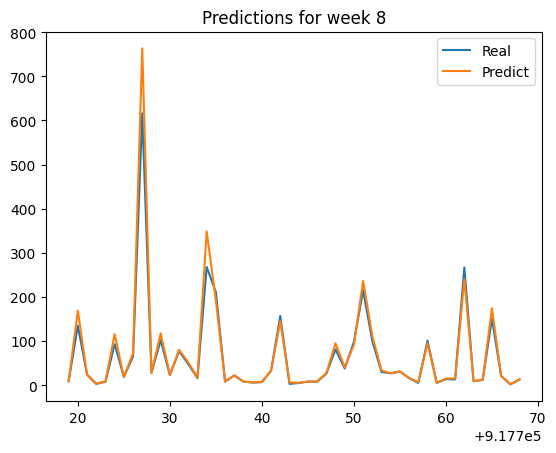

In [91]:
demand_prediction = predictDemand(model2, 8,ags_df)
ags_df.loc[ags_df['Semana'] == 8, 'Demanda_uni_equil'] = demand_prediction[0].astype(int)

In [95]:
y_validate['pred'] = predictions2
y_validate['Semana']=X_validate['Semana'].astype(int)
y_validate.query('Demanda_uni_equil < 50 & Demanda_uni_equil > 40')

,Demanda_uni_equil,pred,Semana
917732,48,51.596983,8
919165,48,46.215294,8
919579,47,50.704505,8
920363,44,43.668149,8
920364,49,47.665248,8
...,...,...,...
1092532,43,48.657575,8
1092551,46,53.551026,8
1092561,49,52.561339,8
1092592,49,54.768989,8
